## Image clasification with Resnet18 using pytorch


#### Overview 
In this notebook , we will explore the [EuroSat](https://github.com/phelber/EuroSAT#) datset, we will then train and optimize residual network (ResNet). We used PyTorch and transfer learning techniques to achieve high accuracy in a relatively short amount of time.

##### Data
first we download the data and unzip it into our work directory. 

In [2]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip EuroSAT.zip

Streaming output truncated to the last 5000 lines.
  inflating: 2750/SeaLake/SeaLake_2206.jpg  
  inflating: 2750/SeaLake/SeaLake_1313.jpg  
  inflating: 2750/SeaLake/SeaLake_263.jpg  
  inflating: 2750/SeaLake/SeaLake_967.jpg  
  inflating: 2750/SeaLake/SeaLake_515.jpg  
  inflating: 2750/SeaLake/SeaLake_1465.jpg  
  inflating: 2750/SeaLake/SeaLake_1817.jpg  
  inflating: 2750/SeaLake/SeaLake_2902.jpg  
  inflating: 2750/SeaLake/SeaLake_2570.jpg  
  inflating: 2750/SeaLake/SeaLake_1004.jpg  
  inflating: 2750/SeaLake/SeaLake_174.jpg  
  inflating: 2750/SeaLake/SeaLake_2111.jpg  
  inflating: 2750/SeaLake/SeaLake_2388.jpg  
  inflating: 2750/SeaLake/SeaLake_1948.jpg  
  inflating: 2750/SeaLake/SeaLake_838.jpg  
  inflating: 2750/SeaLake/SeaLake_2738.jpg  
  inflating: 2750/SeaLake/SeaLake_1999.jpg  
  inflating: 2750/SeaLake/SeaLake_2359.jpg  
  inflating: 2750/SeaLake/SeaLake_2660.jpg  
  inflating: 2750/SeaLake/SeaLake_1775.jpg  
  inflating: 2750/SeaLake/SeaLake_605.jpg  
  inflatin

#### load dataset 

In [25]:
### import libraries and load dataset 
### torch moduls 
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, RandomHorizontalFlip, RandomCrop
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torchvision.models as models
### helper libraries
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from PIL import Image


data_path ="/content/2750"
transform = ToTensor()
dataset = ImageFolder(root=data_path, transform=transform)

#### Data exploration
before we train our model we should take a look at our images.

In [4]:
print(f"Number of images: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
for class_name in dataset.classes:
    num_images = len(dataset[dataset.targets == dataset.class_to_idx[class_name]])
    print(f"{class_name}: {num_images}")


Number of images: 27000
Number of classes: 10
AnnualCrop: 2
Forest: 2
HerbaceousVegetation: 2
Highway: 2
Industrial: 2
Pasture: 2
PermanentCrop: 2
Residential: 2
River: 2
SeaLake: 2


Apparently we got 27000 images with in 10 calasses wich are ; 

* AnnualCrop 
* Forest 
* HerbaceousVegetation
* Highway
* Industrial
* Pasture
* PermanentCrop
* Residential
* River 
* SeaLake


visualisation of some images.

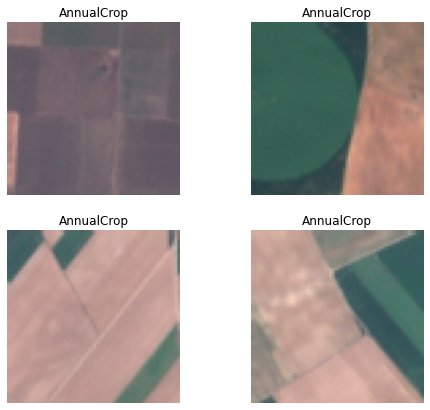

In [20]:
# Plot the first  4 images in the dataset
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
for i, ax in enumerate(axes.flat):
    image, label = dataset[i]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(dataset.classes[label])
    ax.axis("off")
plt.show()


In [21]:
image, label = dataset[0]
print(f"Number of color channels: {image.shape[0]}")

Number of color channels: 3


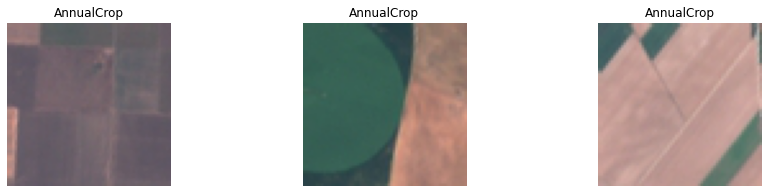

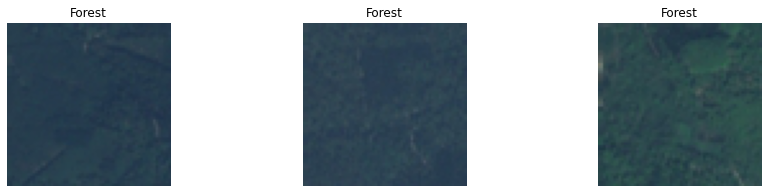

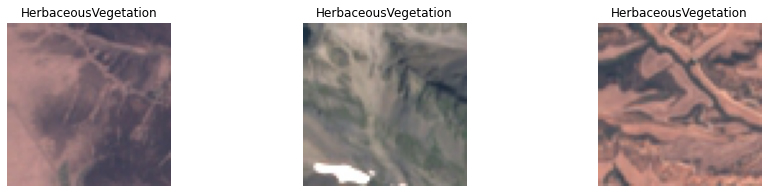

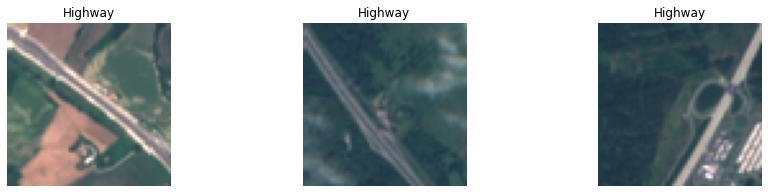

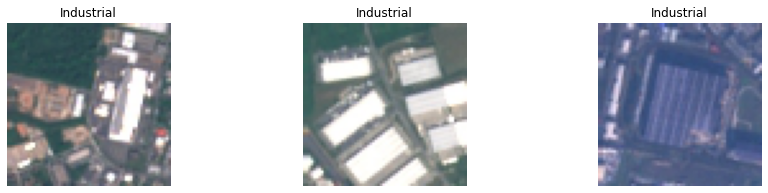

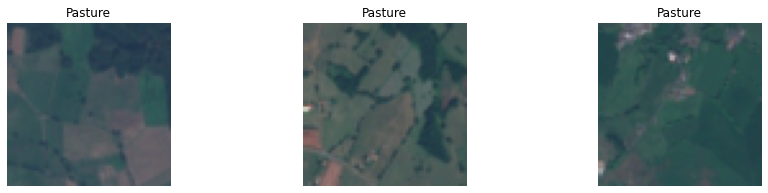

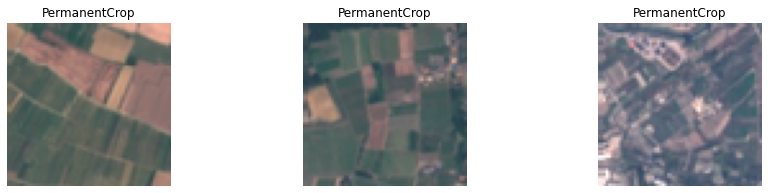

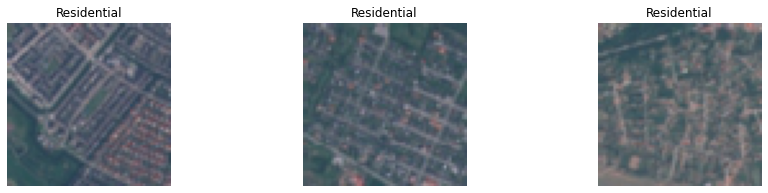

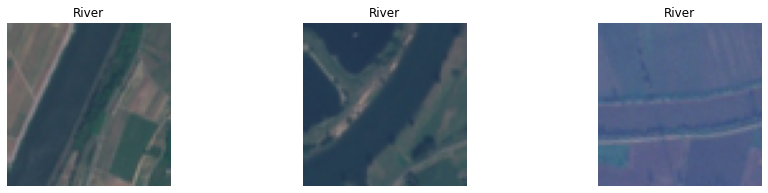

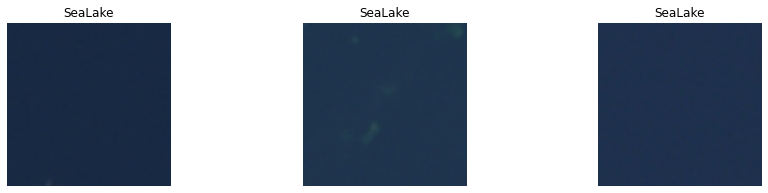

In [22]:
num_images = 3
for class_name in dataset.classes:
    indices = np.where(np.array(dataset.targets) == dataset.class_to_idx[class_name])[0]
    # Plot the first num_images images in the current class
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        image, _ = dataset[indices[i]]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"{class_name}")
        axes[i].axis("off")
    plt.show()




### Check distribution

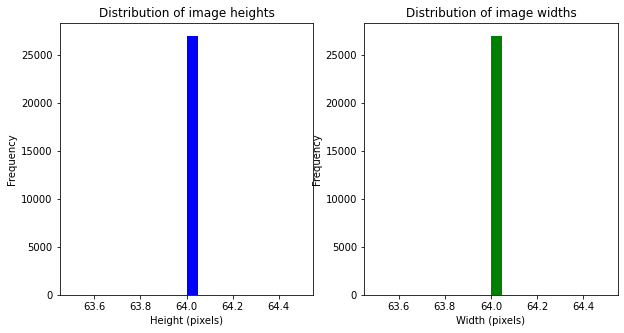

In [8]:
sizes = [Image.open(img[0]).size for img in dataset.imgs]
heights, widths = zip(*sizes)
# Plot the histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(heights, bins=20, color='blue')
ax[0].set_xlabel('Height (pixels)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of image heights')
ax[1].hist(widths, bins=20, color='green')
ax[1].set_xlabel('Width (pixels)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of image widths')
plt.show()

### Data preprocessing 

In [24]:
#data transformations
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#split into training, validation, and test sets
dataset = ImageFolder(root=data_path, transform=transform)
torch.manual_seed(0) #random seed for reproducibility
train_size = int(len(dataset) * 0.8)
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# dataloaders to load the data in batches during training
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)


 #### train and evaluate a resnet

In [26]:
##load preptrained model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
# Define an optimizer and a loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for images, labels in train_loader:
        # Move the data to the GPU
        images = images.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)
    
    # Normalize the training loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    
    # Evaluate the model on the validation data
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            # Compute the validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == labels.data)
    
    # Normalize the validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    
    # Print the training and validation loss and accuracy
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


Epoch [1/10], Train Loss: 0.5362, Train Acc: 0.8322, Val Loss: 0.5220, Val Acc: 0.8381
Epoch [2/10], Train Loss: 0.3275, Train Acc: 0.8947, Val Loss: 0.3037, Val Acc: 0.8985
Epoch [3/10], Train Loss: 0.2700, Train Acc: 0.9132, Val Loss: 0.5873, Val Acc: 0.8400
Epoch [4/10], Train Loss: 0.2422, Train Acc: 0.9198, Val Loss: 0.7356, Val Acc: 0.8037
Epoch [5/10], Train Loss: 0.2116, Train Acc: 0.9308, Val Loss: 0.2090, Val Acc: 0.9263
Epoch [6/10], Train Loss: 0.1922, Train Acc: 0.9383, Val Loss: 0.2396, Val Acc: 0.9315
Epoch [7/10], Train Loss: 0.1781, Train Acc: 0.9431, Val Loss: 0.1388, Val Acc: 0.9526
Epoch [8/10], Train Loss: 0.1773, Train Acc: 0.9428, Val Loss: 0.1403, Val Acc: 0.9507
Epoch [9/10], Train Loss: 0.1513, Train Acc: 0.9515, Val Loss: 0.2525, Val Acc: 0.9263
Epoch [10/10], Train Loss: 0.1443, Train Acc: 0.9544, Val Loss: 0.1492, Val Acc: 0.9500


we got a validation accuracy of 0.94 , our resnet18 model is doing great, let's now put it to the test against the test data.

In [28]:
from sklearn.metrics import accuracy_score
model.eval()
predictions = []
labels = []
for inputs, targets in test_loader:
    inputs = inputs.to("cuda")
    targets = targets.to("cuda")
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    predictions.extend(preds.cpu().numpy())
    labels.extend(targets.cpu().numpy())

# Print the test accuracy
accuracy = accuracy_score(labels, predictions)
print('Test accuracy:', accuracy)


Test accuracy: 0.9440740740740741


### Conclusion 
Overall, this notebook demonstrated the power and flexibility of deep learning and transfer learning for image classification tasks. With the right techniques, we can build accurate models even with limited data.